In [2]:
!pip3 install implicit --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import implicit
import scipy.sparse as sparse

In [3]:
df_train = pd.read_csv(os.path.join('..', 'data', 'training_set.csv'),
                         sep=',',
                         names=['userid', 'itemid', 'styleid', 'rating'],
                         header=0)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [4]:
df_train.head()

,userid,itemid,styleid,rating
0,401,32780,12224,1
1,7548,21688,9020,1
2,7663,1521,568,1
3,1357,3824,1417,1
4,1361,727,263,1


In [5]:
# Cargamos el dataset de testing
df_validation = pd.read_csv(os.path.join('..', 'data', 'validation_set.csv'),
                      sep=',',
                      names=['userid', 'itemid', 'styleid', 'rating'],
                      header=0)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_validation.rating = [1 if x >=3 else 0 for x in df_validation.rating ]


user_items_test = {}

for row in df_validation.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [6]:
df_validation.head()

,userid,itemid,styleid,rating
0,1040,4920,1315,1
1,1306,7348,1199,1
2,932,4073,1199,1
3,6735,16074,1199,1
4,197,39299,3268,1


### Métricas

In [7]:
# Definicion de métricas (No editar)
# Inspirado parcialmente en https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

### Preprocesamiento de los datos a formato sparse

Revisar la impelementación de la sparse matrix para que se ajuste a la estructura de los datasets con los que estamos trabajando

In [8]:
user_items = {}
itemset = set()

for row in df_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []

    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)

matrix = sparse.csr_matrix(sparse_matrix.T)

user_ids = {key: i for i, key in enumerate(user_items.keys())}
user_item_matrix = matrix.T.tocsr()

{401: 0, 7548: 1, 7663: 2, 1357: 3, 1361: 4, 2934: 5, 6606: 6, 530: 7, 2681: 8, 1095: 9, 523: 10, 5925: 11, 335: 12, 6453: 13, 1691: 14, 7628: 15, 6840: 16, 7740: 17, 1615: 18, 1439: 19, 7893: 20, 4060: 21, 303: 22, 3971: 23, 439: 24, 3156: 25, 4007: 26, 1043: 27, 105: 28, 3655: 29, 1221: 30, 3690: 31, 8276: 32, 5754: 33, 136: 34, 7104: 35, 1512: 36, 3608: 37, 7452: 38, 4573: 39, 2909: 40, 579: 41, 5768: 42, 6732: 43, 958: 44, 7027: 45, 230: 46, 24: 47, 8151: 48, 2446: 49, 4489: 50, 4740: 51, 139: 52, 160: 53, 1531: 54, 4741: 55, 376: 56, 1739: 57, 607: 58, 695: 59, 4983: 60, 457: 61, 2932: 62, 2566: 63, 4905: 64, 1372: 65, 3285: 66, 7326: 67, 2768: 68, 7806: 69, 290: 70, 517: 71, 2135: 72, 1445: 73, 872: 74, 2503: 75, 721: 76, 7310: 77, 7222: 78, 3461: 79, 1953: 80, 4899: 81, 3316: 82, 5448: 83, 6437: 84, 3189: 85, 939: 86, 3491: 87, 561: 88, 3881: 89, 7311: 90, 5753: 91, 1663: 92, 4488: 93, 8: 94, 7812: 95, 2693: 96, 30: 97, 4209: 98, 1029: 99, 835: 100, 4999: 101, 5374: 102, 2952: 1

In [9]:
def evaluate_model(model, n):
  mean_ap = 0. # o MAP
  mean_ndcg = 0.
  for u in user_items_test.keys():
    rec = model.recommend(u, user_item_matrix[u], n)[0]
    rel_vector = [np.isin(user_items_test[u], rec, assume_unique=True).astype(int)]
    mean_ap += average_precision_at_k(rel_vector, n)
    mean_ndcg += ndcg_at_k(rel_vector, n, len(user_items_test[u]))

  mean_ap /= len(user_items_test)
  mean_ndcg /= len(user_items_test)

  return mean_ap, mean_ndcg

## ALS (Implicit Feedback)

In [10]:
# Definimos y entrenamos el modelo con optimización ALS
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10)
model_als.fit(user_item_matrix)

/home/pedropalmav/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 24 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

Ejemplo de recomendación y búsqueda de items similares con los factores latentes ya entrenados:

In [11]:
maprec, ndcg = evaluate_model(model_als, n=10)
print('map: {}\nndcg: {}'.format(maprec, ndcg))

map: 0.00013455235466620664
ndcg: 0.0009470734844210744


In [12]:
user_id = user_ids[5401]
ranking = list(model_als.recommend(userid=user_id, user_items=user_item_matrix[user_id], N=10)[0])
print(ranking)

[531, 55, 712, 33, 533, 58, 989, 773, 905, 781]


## Análisis de sensibilidad

In [13]:
factors_values = [50, 75, 100, 150, 200]
factors_map = []
factors_ndcg = []

for f in factors_values:
  model_als = implicit.als.AlternatingLeastSquares(factors=f, iterations=10, use_gpu=False)
  model_als.fit(user_item_matrix)
  map, ndcg = evaluate_model(model_als, n=10)

  factors_map.append(map)
  factors_ndcg.append(ndcg)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

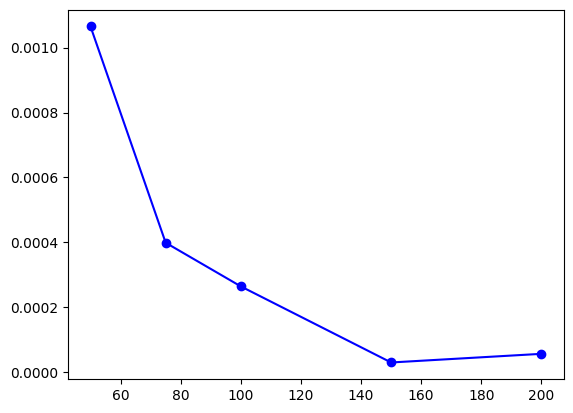

In [14]:
import matplotlib.pyplot as plt

plt.plot(factors_values, factors_map, "bo-")
plt.show()

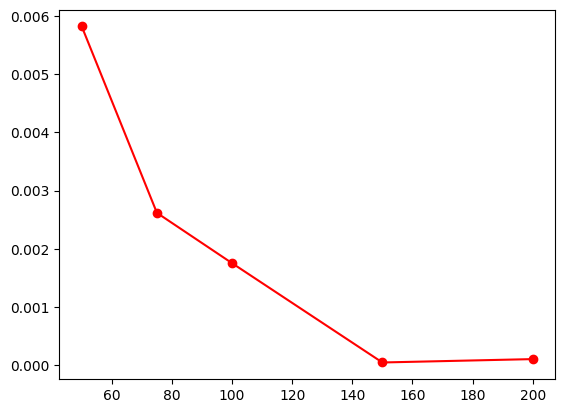

In [15]:
plt.plot(factors_values, factors_ndcg, "ro-")
plt.show()

In [16]:
iterations_values = [5, 7, 10, 12, 15]
iterations_map = []
iterations_ndcg = []

for i in iterations_values:
  model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=i, use_gpu=False)
  model_als.fit(user_item_matrix)
  map, ndcg = evaluate_model(model_als, n=10)

  iterations_map.append(map)
  iterations_ndcg.append(ndcg)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

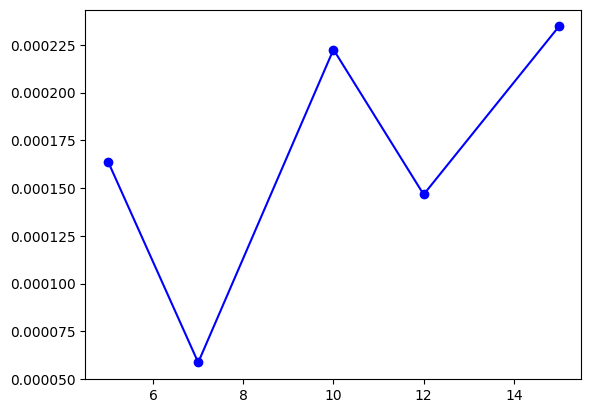

In [17]:
plt.plot(iterations_values, iterations_map, "bo-")
plt.show()

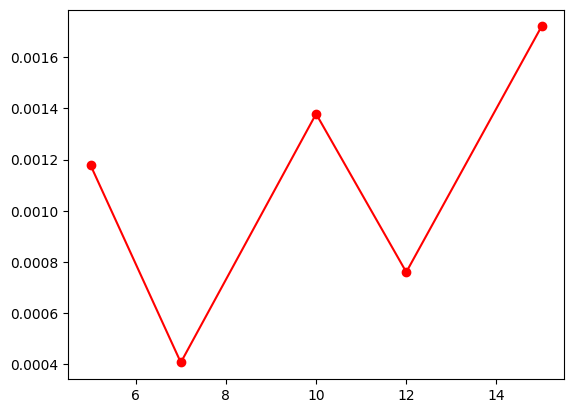

In [18]:
plt.plot(iterations_values, iterations_ndcg, "ro-")
plt.show()

Para hacer las listas de recomendación, hay que utilizar el método `model.recommend` y debe hacerse con el dataset de validación (NO CON EL DE TRAINING)

## Ranking con datos de testeo

In [19]:
import json

test = json.load(open(os.path.join("..", "templates", "ranking_template_fill.json")))

In [21]:
for user in test.keys():
    user_id = user_ids[int(user)]
    ranking = list(model_als.recommend(userid=user_id, user_items=user_item_matrix[user_id], N=10)[0])
    ranking = [int(r) for r in ranking]
    test[user] = ranking

In [22]:
with open(os.path.join("..", "predictions", "als_ranking.json"), "w") as file:
    json.dump(test, file, indent=4)